Импорты

In [65]:
#Импортирование библиотек
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, ShuffleSplit, KFold
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, log_loss
import py7zr
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import DMatrix
from xgboost import plot_importance
from sklearn.metrics import f1_score
from sklearn.utils import class_weight

Загружаю данные

In [86]:
data = pd.read_csv('contest_train.csv.zip')

In [87]:
#data.describe()

In [88]:
y = data.iloc[:,1]
x=data.iloc[:,2:]

In [89]:
#меняю пропуски на median
#сейчас на 0 x=x.fillna(0) 0.45894617562721157
#x=x.fillna(x.median())
#сейчас на моду 0.460795827888902
x=x.fillna(x.mode())
#тут выкидываю 3 5 249
#x=x.drop (columns = ['FEATURE_3', 'FEATURE_5', 'FEATURE_249']) 
#0.460795827888902 дропать нет толку
#x.head()

In [90]:
#*******
train_x, test_x, train_y, test_y =  train_test_split(x, y, test_size=0.2, random_state=42)

Тут будем считать веса для тренировки модели

In [91]:
# алгоритм меньшее делим на каждое - получаем от 1 и ниже. 
#их выставляем соответствующим в талице целям
train_y.value_counts(normalize=True)

0    0.708860
1    0.230169
2    0.060971
Name: TARGET, dtype: float64

In [92]:
v=[0.08601275287080664729283638518184,0.26489666288683532534789654558172,1.0]

In [93]:
#class_weights = list(class_weight.compute_class_weight('balanced',
#                                             np.unique(train_y),
#                                             train_y))

In [94]:
#class_weights

In [95]:
# СЮДА СЧЁТ ВЕСОВ
#Их считаем пока по тренировочной выборке, общее потом
#class_weights = list(class_weight.compute_class_weight('balanced',
#                                             np.unique(train_y),
#                                             train_y))

w_array = np.ones(train_y.shape[0], dtype = 'float')
for i, val in enumerate(train_y):
    w_array[i] = v[val]

In [96]:
#for row in w_array:
#    print(row)

Делаем поиск оптимальных гиперпараметров


In [97]:
#https://xgboost.readthedocs.io/en/latest/parameter.html?highlight=num_class
#http://biostat-r.blogspot.com/2016/08/xgboost.html
"""def score_func(estimator, x, y):
    ntree_limit=estimator.get_booster().best_ntree_limit
    score1 = log_loss(y, estimator.predict(x, ntree_limit), labels=list(range(3)))
    return -score1

xgb = XGBClassifier(
    objective = 'multi:softprob',
    eval_metric = 'mlogloss',
    num_class = 3,
    #nthread=4,
    seed=10
)

parameters = {
    'max_depth': range (5, 6, 1), #(4, 7, 1),
    'learning_rate': [0.01], #[0.1, 0.01, 0.05]
    'eta': [0.1], #'eta': [0.1, 0.2, 0.3]
    'alpha': [0],
    'lambda': [1]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=parameters,
    scoring = score_func,
    n_jobs = 10,
    cv = 3,
    verbose=True
)

grid_search.fit(train_x, train_y)
"""

"def score_func(estimator, x, y):\n    ntree_limit=estimator.get_booster().best_ntree_limit\n    score1 = log_loss(y, estimator.predict(x, ntree_limit), labels=list(range(3)))\n    return -score1\n\nxgb = XGBClassifier(\n    objective = 'multi:softprob',\n    eval_metric = 'mlogloss',\n    num_class = 3,\n    #nthread=4,\n    seed=10\n)\n\nparameters = {\n    'max_depth': range (5, 6, 1), #(4, 7, 1),\n    'learning_rate': [0.01], #[0.1, 0.01, 0.05]\n    'eta': [0.1], #'eta': [0.1, 0.2, 0.3]\n    'alpha': [0],\n    'lambda': [1]\n}\n\ngrid_search = GridSearchCV(\n    estimator=xgb,\n    param_grid=parameters,\n    scoring = score_func,\n    n_jobs = 10,\n    cv = 3,\n    verbose=True\n)\n\ngrid_search.fit(train_x, train_y)\n"

In [98]:
#print(grid_search.best_params_)

In [99]:
xgb_param = {
          #'booster': 'dart', # у меня лучше результат на ней 0.4695226792212739 class 20!
          'booster': 'gbtree', #0.4647882548794115
          'objective': 'multi:softprob',
             #multi:softmax - можно попробовать - меняй в 2х местах
             #multi:softmax: set XGBoost to do multiclass classification using 
             #the softmax objective, you also need to set num_class(number of classes)
          'eval_metric' : 'mlogloss',
          'learning_rate' : 0.1,#0.05 - 0.4560421055871875 такое-лучше: 0.01
          'max_depth' : 5,
            # 9-0.4635205623123519
            # 3-0.4501095475496298
            # 10-0.4649517513067532
          'num_class' : 3, # 20 - 0.4695226792212739, оставлю 3 как положено
          #9 - 0.4560421055871875 3-0.4564400840387614 9-0.45894617562721157
          #'nthread': 4,
          'subsample': 0.5,
          #'eta': 0.01, #0.4647882548794115 !лучше такое однозначно
          'eta': 0.1, #0.4647882548794115
          'alpha': 0,
          'lambda': 1,
          'gamma': 0.01, #просто пробую её выставить
          'seed': 10}

#dtrain_xgb = xgb.DMatrix(train_x, label=train_y) #*******
dtrain_xgb = xgb.DMatrix(train_x, label=train_y, weight = w_array)

xbg_result = xgb.cv(xgb_param, 
                    dtrain_xgb, 
                    num_boost_round=3000, #300 600?
                    nfold=3,
                    stratified=True, 
                    early_stopping_rounds=50, 
                    verbose_eval=100, 
                    show_stdv=True)

[0]	train-mlogloss:1.06612+0.00070	test-mlogloss:1.07354+0.00111


In [100]:
num_round_xgb = len(xbg_result['test-mlogloss-mean'])
print('num boost rounds xgb=' + str(num_round_xgb))

num boost rounds xgb=47


In [101]:
xgb_cl = xgb.train(xgb_param, dtrain_xgb, num_boost_round=num_round_xgb)

In [102]:
#*******
xgtest = xgb.DMatrix(test_x)
y_pred8 = xgb_cl.predict(xgtest)

In [103]:
#*******
best_preds = np.asarray([np.argmax(line) for line in y_pred8])
f1_score(test_y, best_preds, average='macro')

0.4945980142163082

In [104]:
#подставить в нумкласс 9-ку 0.45894617562721157 -бред, но работает пока
#dart !! писец долго считает - дождусь, пока пишу загадочный параметр
# и ещё загадочный параметр построй его по примерам !
#лёрнинг рейт вернуть 0.05 - просто ускорение, но не качество
#multi:softmax: !!! там не забудь макс исправить! 

Загрузка файла для ответов

In [105]:
data_pred = pd.read_csv('contest_test.csv.zip')

In [106]:
x_pred=data_pred.iloc[:,1:]

 Предсказание классов

In [107]:
xgpred = xgb.DMatrix(x_pred)
y_pred = xgb_cl.predict(xgpred)
Predicted=np.asarray([np.argmax(line) for line in y_pred])

Делаю и пишу выходные данные

In [108]:
data_pred['Predicted']=Predicted

In [109]:
data_pred.to_csv('data1.csv', index=False, columns =['ID','Predicted'])

Отрисую важные параметры

In [110]:
sns.set(font_scale = 1.5)
#xgb.plot_importance(xgb_cl) #тут рисует всё - нечитабельно вообще.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

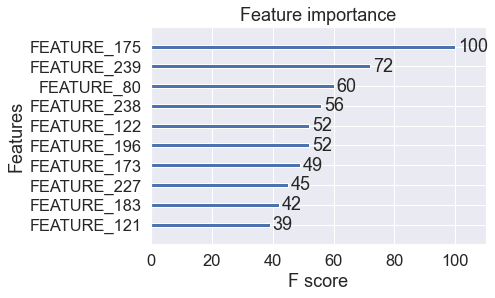

In [111]:
xgb.plot_importance(xgb_cl, max_num_features = 10)

Веса для классов в DMatrix

scale_pos_weight [default=1]
Контролировать баланс положительных и отрицательных весов. 
Типичное значение для рассмотрения: sum(negative instances) / sum(positive instances)
 
 У меня многоклассовый, поэтому веса для каждого примера считаю:
 xgbmodel.fit(X_train, y_train,sample_weight=weights_train)

в этой строчке надо добавить веса

dtrain_xgb = xgb.DMatrix(x, label=y,weight = *weight array for individual weights*)

Их вес будет (деление наименьшего класса на другие)


In [ ]:
# ПИШУ СЧЁТ ВЕСОВ
#https://qastack.ru/datascience/16342/unbalanced-multiclass-data-with-xgboost

"""class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(train['class']),
                                             train['class']))

w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val-1]
"""
#ЭТО в ****** для всего и части тернировок надо менять будет строчки и тестить
######dtrain_xgb = xgb.DMatrix(X, y, sample_weight=w_array)
######dtrain_xgb = xgb.DMatrix(train_x, label=train_y, sample_weight=w_array)

Идея обучить на всей выборке, не разбивая вообще и на сдачу

In [ ]:
# Меняю в#******* на строчку
dtrain_xgb = xgb.DMatrix(x, label=y)
# ещё в 3-х местах не считаю, тк там нет данных
# их пометил так же #*******
# Загрузка файла для ответов - отсюда уже нормальные предсказания